In [7]:
import train_p1 as p1
import sys
import torch
import torch.nn as nn
from torch.nn.modules.dropout import Dropout
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torchvision.transforms.autoaugment import AutoAugmentPolicy
from pytorch_pretrained_vit import ViT
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

import glob
import os
import numpy as np
import pandas as pd
import random
from PIL import Image
from torchsummary import summary
import matplotlib.pyplot as plt
import torchvision.utils as vutils

In [8]:
## Hyper parameters ##
image_size = 384
channel_size = 3
num_classes = 37
epochs = 30
save_model_dir = './models/'
#######################
save_model_dir = 'models'
model_path = os.path.join(save_model_dir,'vit_e4_0.9567.pth')

# Position embedding visualization

In [ ]:
def get_features(name):
    def hook(model, input, output):
        features[name] = output.detach()
    return hook

testset = p1.p1_inference(root='hw3_data/p1_data/val')
print('# images in testset:', len(testset))

testset_loader = DataLoader(testset, batch_size=1, shuffle=False)

model = ViT('L_16_imagenet1k', pretrained=True)
model.fc = nn.Linear(1024,num_classes)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Device used:', device)

model.to(device)
model.load_state_dict(torch.load(model_path))

model.patch_embedding.register_forward_hook(get_features('patch'))
model.positional_embedding.register_forward_hook(get_features('position'))
model.eval()
# summary(model,(3,384,384))
dataiter = iter(testset_loader)
image,_ = dataiter.next()
image = image.to(device)

features = {}
with torch.no_grad():
    predict = model(image)
    patch = features['patch']
    x = patch.flatten(2).transpose(1, 2)
    position = features['position'][0][1:,:]
    position = position - x[0]
    p = torch.matmul(position,position.T)
    p = p / (position.norm() * position.T.norm())
    print(p.shape)

In [ ]:
pp = p.reshape(576,24,24)
print(pp.shape)
fig = plt.figure(figsize=(24,24))
for i, img in enumerate(pp):
    fig.add_subplot(24,24,i+1)
#     plt.subplot(24,24,i+1)
    plt.axis("off")
    plt.imshow(img.detach().cpu())
fig.suptitle('Visualization results',verticalalignment='bottom',fontsize='40')
plt.show()

# Attention map visualization

In [ ]:
def get_features(name):
    def hook(model, input, output):
        features[name] = output.detach()
    return hook

filenames = glob.glob(os.path.join('attn', '*.jpg'))
transform = transforms.Compose([
    transforms.Resize((image_size,image_size)),
    transforms.ToTensor(),
#     transforms.Normalize([0.5],[0.5])
])

model = ViT('L_16_imagenet1k', pretrained=True)
model.fc = nn.Linear(1024,num_classes)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Device used:', device)

model.to(device)
model.load_state_dict(torch.load(model_path))
model.transformer.blocks[23].attn.drop.register_forward_hook(get_features('attn'))

model.eval()

# dataiter = iter(testset_loader)
# image,_ = dataiter.next()
# image = image.to(device)

img = Image.open(filenames[2]).convert('RGB')
image = transform(img)
img = transforms.ToPILImage()(image)
plt.imshow(img)

features = {}
with torch.no_grad():
    image = image.view(1,3,384,384)
    predict = model(image.cuda())
    attn = features['attn'][0][1:,:]
    print(attn.shape)
    aa = torch.norm(attn,dim=1)
    aa /= aa.max()
    print(aa.shape)

Loaded pretrained weights.
Device used: cuda:0
torch.Size([24, 577, 577])
torch.Size([24, 577, 577])
torch.Size([24, 577, 577])


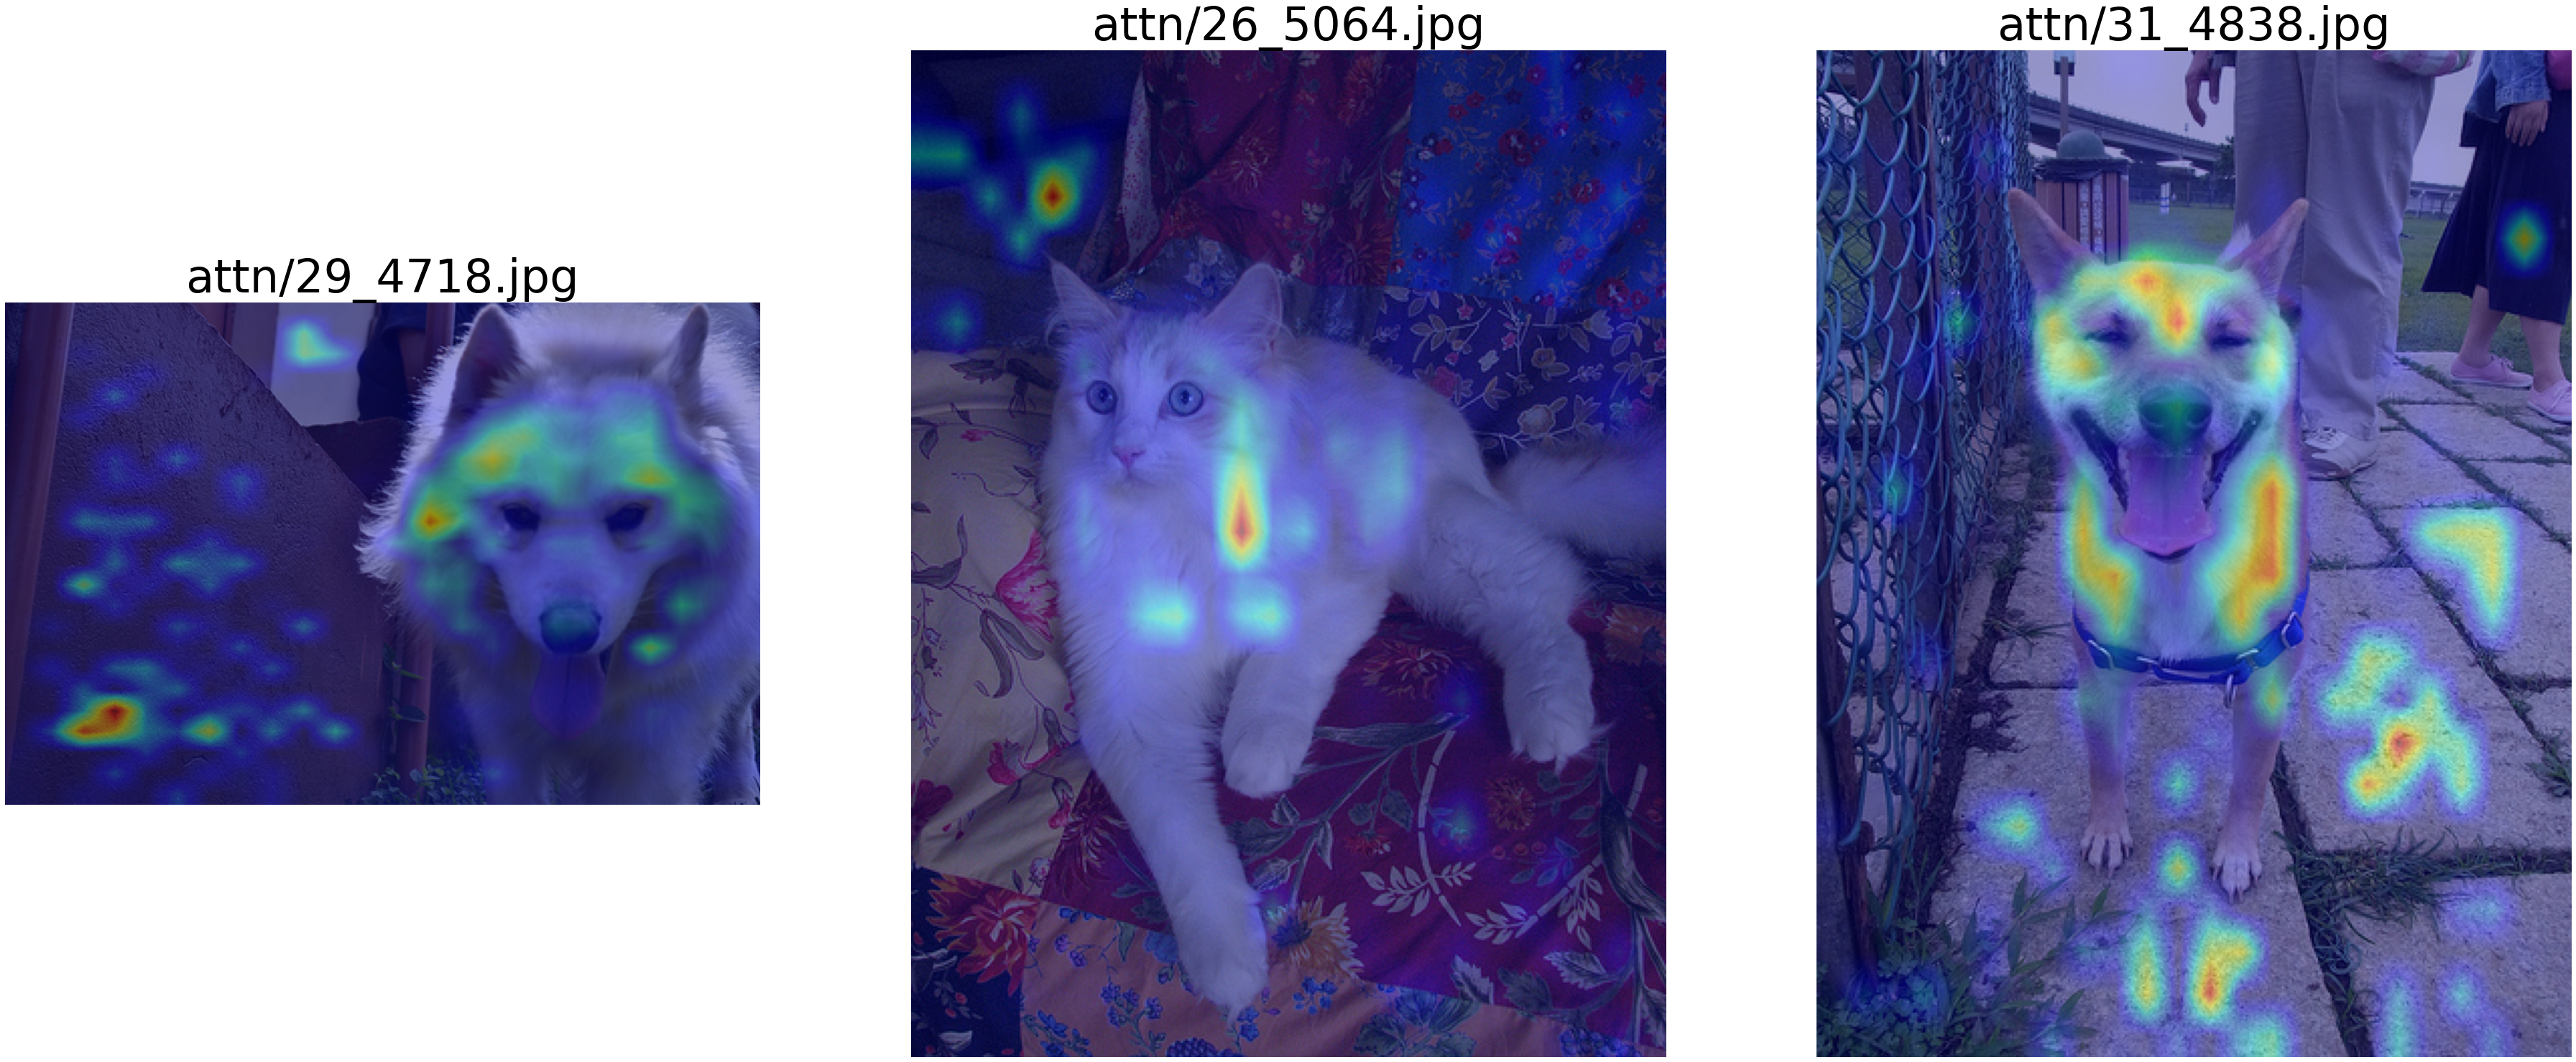

In [21]:
import cv2
filenames = glob.glob(os.path.join('attn', '*.jpg'))
transform = transforms.Compose([
    transforms.Resize((image_size,image_size)),
    transforms.ToTensor(),
    transforms.Normalize([0.5],[0.5])
])

model = ViT('L_16_imagenet1k', pretrained=True)
model.fc = nn.Linear(1024,num_classes)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Device used:', device)

model.to(device)
model.load_state_dict(torch.load(model_path))
model.eval()
fig, ax = plt.subplots(nrows=1,ncols=3,figsize=(64, 64))
for i in range(3):
    img = Image.open(filenames[i]).convert('RGB')
    image = transform(img)
    x,atten_weights = model.forward(image.unsqueeze(0).cuda())
    print(atten_weights.shape)
    im = Image.open(filenames[i])
#     im = cv2.imread(filenames[i])
    atten_weights = atten_weights.to('cpu')
    for att_mat in [atten_weights[21]]:
        residual_att = torch.eye(att_mat.size(1))
        aug_att_mat = att_mat + residual_att
        aug_att_mat = aug_att_mat / aug_att_mat.sum(dim=-1).unsqueeze(-1)
        joint_attentions = torch.zeros(aug_att_mat.size())
        joint_attentions[0] = aug_att_mat[0]
        for n in range(1, aug_att_mat.size(0)):
            joint_attentions[n] = torch.matmul(aug_att_mat[n], joint_attentions[n - 1])
        v = joint_attentions
        grid_size = int(np.sqrt(aug_att_mat.size(-1)))
        mask = v[0,1:].reshape(grid_size, grid_size).detach().numpy()
        mask = mask / mask.max()
#         print(mask.shape)
#         im = cv2.resize(im,(192,192),interpolation=cv2.INTER_AREA)
        mask = cv2.resize(mask / mask.max(), im.size)[..., np.newaxis]
        ax[i].set_title(filenames[i],fontdict={'fontsize':64})
        _ = ax[i].imshow(im)
        _ = ax[i].imshow(mask,interpolation='gaussian',alpha=0.4,cmap='jet')
        ax[i].axis('off')

In [ ]:
a = aa.reshape((24,24))
# transform1 = transforms.Compose([
#     transforms.Resize((24,24)),
#     transforms.ToTensor(),
# #     transforms.Normalize([0.5],[0.5])
# ])
img = Image.open(filenames[2]).convert('RGB')
img = img.resize((384,384))
extent = 0,384,0,384
plt.figure(figsize = (8,8))
plt.imshow(img,extent=extent)
a = a.detach().cpu()
plt.imshow(a,interpolation='gaussian',alpha=0.4,cmap='jet',extent=extent)
plt.axis('off')
# plt.colorbar()
plt.show()

In [ ]:
print(model)

In [ ]:
summary(model,(3,384,384))